In [1]:
using LinearAlgebra, Random, Plots
using MLJ, DataFrames, StatsPlots, StatsBase

## Regressão linear usando diferentes métodos e pacotes

In [2]:
X, y = @load_boston;
df = hcat(DataFrame(X), DataFrame((target = y)))
first(df, 5)

Row,Crim,Zn,Indus,NOx,Rm,Age,Dis,Rad,Tax,PTRatio,Black,LStat,target
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.00632,18.0,2.31,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98,24.0
2,0.02731,0.0,7.07,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14,21.6
3,0.02729,0.0,7.07,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
4,0.03237,0.0,2.18,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.9,5.33,36.2


#### obter a matriz da correlação para selecionar apenas um feature, o mais correlacionado com target.

In [3]:
df_cormat = cor(Matrix(df))

13×13 Matrix{Float64}:
  1.0       -0.200469   0.406583  …  -0.385064   0.455621  -0.388305
 -0.200469   1.0       -0.533828      0.17552   -0.412995   0.360445
  0.406583  -0.533828   1.0          -0.356977   0.6038    -0.483725
  0.420972  -0.516604   0.763651     -0.380051   0.590879  -0.427321
 -0.219247   0.311991  -0.391676      0.128069  -0.613808   0.69536
  0.352734  -0.569537   0.644779  …  -0.273534   0.602339  -0.376955
 -0.37967    0.664408  -0.708027      0.291512  -0.496996   0.249929
  0.625505  -0.311948   0.595129     -0.444413   0.488676  -0.381626
  0.582764  -0.314563   0.72076      -0.441808   0.543993  -0.468536
  0.289946  -0.391679   0.383248     -0.177383   0.374044  -0.507787
 -0.385064   0.17552   -0.356977  …   1.0       -0.366087   0.333461
  0.455621  -0.412995   0.6038       -0.366087   1.0       -0.737663
 -0.388305   0.360445  -0.483725      0.333461  -0.737663   1.0

#### Visualizar a matriz de correlação

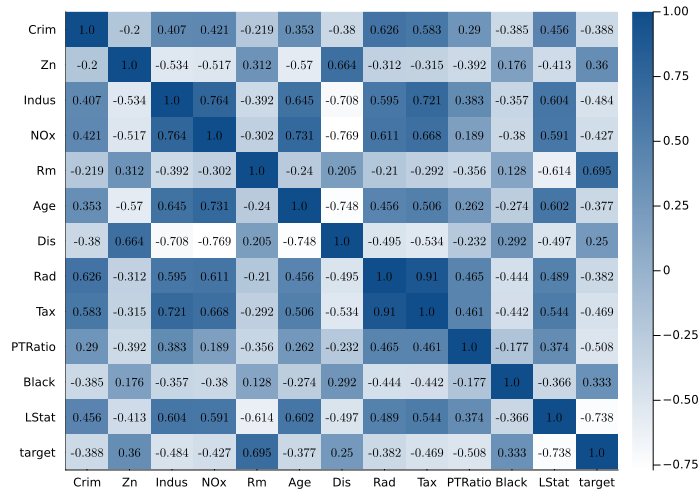

In [4]:
cols = names(df)
ncol, nrow = size(df_cormat)

heatmap(
    df_cormat, xticks=(1:ncol, cols), yticks=(1:nrow, cols),
    size=(700, 500), fc=cgrad([:white, :dodgerblue4]), yflip=true,
    annotate=([(j, i, text(round(df_cormat[i, j], digits=3),
                8, "Computer Modern", :black)) for i in 1:nrow for j in 1:ncol])
)

* > ##### Implementação com pacote LinearAlgebra (nativa).

In [ ]:
Random.seed!(42)
m = 100
X = 8 *  rand(m)
X_b = hcat(ones(m), X)
y = 3 .* X .+ 4 .+ rand(m);

#= X_train, y_train = make_regression(200, 1)
X_test, y_test   = make_regression(100, 1)

x_train, x_test = Tables.matrix(X_train), Tables.matrix(X_test) =#

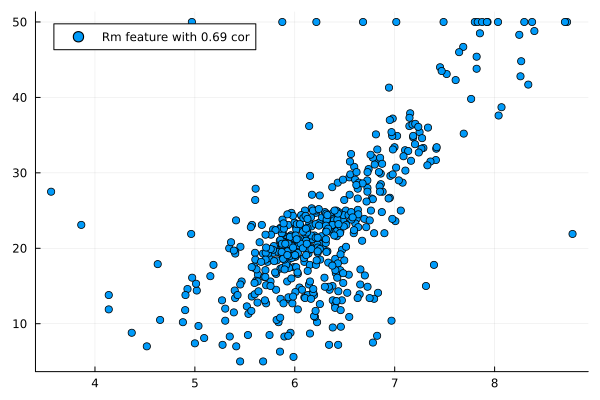

In [113]:
scatter(X.Rm, y, lab="Rm feature with 0.69 cor")

##### separando dados de treino em 0.7 e test 0.3

In [5]:
(X_train, X_test), (y_train, y_test) = partition((df.Rm, df.target), 0.7, rng=42, multi=true);
X_train, X_test = DataFrame(Rm = X_train), DataFrame(Rm = X_test);

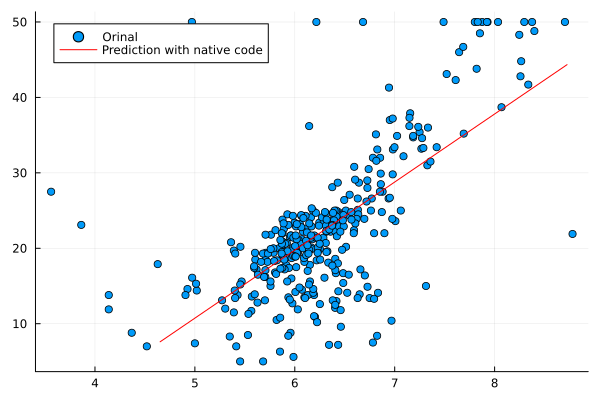

In [11]:
begin
    @kwdef mutable struct Params
        Θ::Any = []
    end

    function norm_equation!(params::Params, X::Array, y::Array)
        params.Θ = inv(X' * X) * X' * y; #pinv(X_b)*y
    end

    function predict(params::Params, X::Array)
        return X*params.Θ
    end

    #= X_n = [0.5, 4.7, 6.8, 8.3]
    X_nb = hcat(ones(4), X_n)
    =#
    
    params = Params()
    x_train = hcat(ones(length(X_train.Rm)), X_train.Rm)
    x_test  = hcat(ones(length(X_test.Rm)), X_test.Rm)

    norm_equation!(params, x_train, y_train);
    y_pred0 = predict(params, Matrix(x_test)) 

    #= p0 = scatter(X, y, lab="Orinal")
    p1 = plot!(X_n, y_pred, lab="Prediction", c=:Red) =#

    scatter(X_train.Rm, y_train, lab="Orinal");
    p0 = plot!(X_test.Rm, y_pred0, lab="Prediction with native code", c=:Red);
end

* > ##### Implementação com glm do MLJ

#### Carregar o pacote

In [20]:
LinearRegGLM = @load LinearRegressor pkg=GLM verbosity=0 

MLJGLMInterface.LinearRegressor

In [ ]:
#instanciar o modelo
glm_model = LinearRegGLM()

LinearRegressor(
  fit_intercept = true, 
  dropcollinear = false, 
  offsetcol = nothing, 
  report_keys = [:deviance, :dof_residual, :stderror, :vcov, :coef_table])

In [ ]:
mach1 = machine(glm_model, X_train, y_train) |> MLJ.fit! #treinamento
y_pred1 = MLJ.predict(mach1, X_test); #previ

In [ ]:
#scatter(X_train.Rm, y_train, lab="Orinal");
#p1 = plot!(X_test.Rm, y_pred1, lab="Prediction with glm", c=:Red);

* > #### Implementação do MLJ - MLJInterface

In [13]:
LinearRegMLJ = @load LinearRegressor pkg=MLJLinearModels verbosity=0 #carregar o modelo

MLJLinearModels.LinearRegressor

In [ ]:
mlj_model = LinearRegMLJ() #instanciar o modelo

LinearRegressor(
  fit_intercept = true, 
  solver = nothing)

In [ ]:
mach2 = machine(mlj_model, X_train, y_train) |> MLJ.fit! #treino

y_pred2 = MLJ.predict(mach2, X_test);

#### plotar os resultados para comparar as implementações

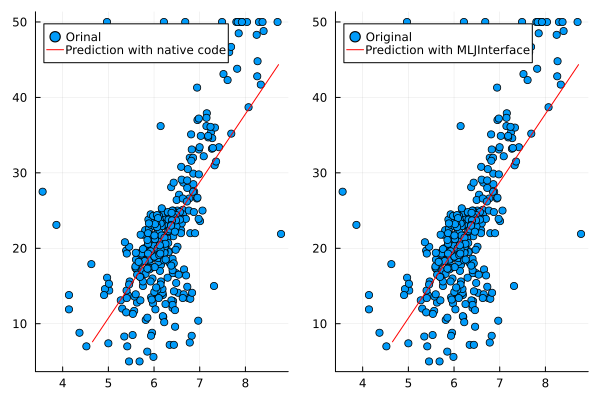

In [17]:
scatter(X_train.Rm, y_train, lab="Original")
p2 = plot!(X_test.Rm, y_pred2, c=:red, lab="Prediction with MLJInterface")

plot(p0, p2)

In [18]:
fitted_params(mach2)

(coefs = [:Rm => 9.021330907185613],
 intercept = -34.36641059784872,)

In [27]:
report(mach2)

In [24]:
params.Θ

2-element Vector{Float64}:
 -34.36641059784756
   9.021330907185472

In [25]:
MLJ.fitted_params(mach1)

(features = [:Rm],
 coef = [9.021330907185602],
 intercept = -34.366410597848656,)

In [23]:
MLJ.fitted_params(mach2)

(coefs = [:Rm => 9.021330907185613],
 intercept = -34.36641059784872,)

#### avaliação do modelo

In [60]:
evaluate!(mach2, resampling=CV(nfolds=5), measure=[rms, rmse], verbosity=0)

PerformanceEvaluation object with these fields:
  model, measure, operation,
  measurement, per_fold, per_observation,
  fitted_params_per_fold, report_per_fold,
  train_test_rows, resampling, repeats
Extract:
┌───┬────────────────────────┬───────────┬─────────────┐
│   │ measure                │ operation │ measurement │
├───┼────────────────────────┼───────────┼─────────────┤
│ A │ RootMeanSquaredError() │ predict   │ 6.9         │
│ B │ RootMeanSquaredError() │ predict   │ 6.9         │
└───┴────────────────────────┴───────────┴─────────────┘
┌───┬────────────────────────────────┬─────────┐
│   │ per_fold                       │ 1.96*SE │
├───┼────────────────────────────────┼─────────┤
│ A │ [8.24, 7.15, 7.07, 6.25, 5.48] │ 1.02    │
│ B │ [8.24, 7.15, 7.07, 6.25, 5.48] │ 1.02    │
└───┴────────────────────────────────┴─────────┘
